# Find nights with Auxtel Spectra reconstructed in butler repo/main

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-01-11
- last update : 2024-01-11
- affiliation : IJCLab/IN2P3/CNRS


## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time

In [2]:
import matplotlib.ticker
%matplotlib inline

In [3]:
import spectractor
from spectractor.simulation.throughput import load_transmission,plot_transmission_simple,TelescopeTransmission
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.config import load_config,set_logger
import os,sys

In [4]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [5]:
import lsst.daf.butler as dafButler

repo = "/repo/main"
#repo = "/repo/embargo"
# repo = "LATISS"
butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
    #if "u/jneveu" in c and "auxtel_atmo" in c:
    #if "u/dagoret" in c:
    if "u/dagoret" in c and "auxtel_atmo" in c:
        print(c)

u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsNOPTC_rebin2_231220
u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsNOPTC_rebin2_231220/20231221T070720Z
u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsNOPTC_rebin2_231220/20231221T070932Z
u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsNOPTC_rebin2_231221
u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsNOPTC_rebin2_231221/20231222T080958Z


## Config

### Config collection

In [6]:
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208"
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208"

# all spectra from September 2022 to december 2023
#the reconstruction done by  LambdaMin = 350.0 and spectractor v3.0.3 in 2023/12/21
#my_collection = "u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221"
my_collection = "u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsNOPTC_rebin2_231221"

### Config Auxtel

In [7]:
#config_path = "~/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
#config_path = "/home/d/dagoret/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
config_fullpath = os.path.join(spectractor.__path__[0],"../config/auxtel.ini")
throughput_filename="multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"

In [8]:
load_config(config_fullpath)

## Check the presence of the spectra

### select the date of observation

### Fitted param file output name

- Note each date is overwritted inside the hdf5 file

In [9]:
#fitted_paramfile = f"fitted_atmparamfile_{DATEOBS}.hdf5"
fitted_paramfile = "fitted_atmparamfile.hdf5"

## Access to spectra using the butler

In [10]:
#where = f"instrument='LATISS' and visit.day_obs={DATEOBS}" 
where = "instrument='LATISS' "
records = list(butler.registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection))
# records = list(butler.registry.queryDimensionRecords('visit', datasets='raw', where=where))

In [11]:
print(">>> Number of records : ",len(records))
records[-1]

>>> Number of records :  1033


visit.RecordClass(instrument='LATISS', id=2022063000590, physical_filter='empty~holo4_003', name='AT_O_20220630_000590', day_obs=20220630, seq_num=590, exposure_time=30.0, target_name='spec:HD185975', observation_reason='object', science_program='unknown', azimuth=179.79635589236568, zenith_angle=57.08248490252299, region=ConvexPolygon([UnitVector3d(0.02673171371968633, -0.03172662714532161, -0.9991390476863521), UnitVector3d(0.029896987861373864, -0.03634047412467818, -0.9988921563698508), UnitVector3d(0.025306381604536726, -0.0394901941469411, -0.9988994502032337), UnitVector3d(0.022141108035933166, -0.03487634666045707, -0.9991463415228826)]), timespan=Timespan(begin=astropy.time.Time('2022-07-01 06:30:58.586982', scale='tai', format='iso'), end=astropy.time.Time('2022-07-01 06:31:28.822000', scale='tai', format='iso')))

### List first of first records

       visit:
          instrument
          id
          physical_filter
          name: 'AT_O_20231220_000354'
         day_obs
         seq_num
         exposure_time
         target_name
         observation_reason
         science_program: 
         azimuth
         zenith_angle
         timespan

In [12]:
df_spec = pd.DataFrame(columns=['id',
                                'name',
                                'day_obs', 
                                'seq_num',
                                'time_start',
                                'time_end', 
                                'target',
                                'filter',
                                'exposure_time',
                                'azimuth',
                                'zenith',
                                'obs_reason',
                                'science_program',
                                'jd',
                                'mjd'])

In [13]:
for count, info in enumerate(registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection)):
       
    try:
        df_spec.loc[count] = [info.id, info.name, info.day_obs, info.seq_num,pd.to_datetime(info.timespan.begin.to_string()),pd.to_datetime(info.timespan.end.to_string()) ,
                                  info.target_name, info.physical_filter, info.exposure_time, info.azimuth,info.zenith_angle, info.observation_reason, info.science_program,
                                  info.timespan.begin.jd,info.timespan.begin.mjd ]
    except:
        print(">>>   Unexpected error:", sys.exc_info()[0])
        info_timespan_begin_to_string = "2021-01-01 00:00:00.00"
        info_timespan_end_to_string = "2051-01-01 00:00:00.00"
        info_timespan_begin_jd = 0
        info_timespan_begin_mjd = 0
        df_spec.loc[count] = [info.id, info.name, info.day_obs, info.seq_num,
                                  pd.to_datetime(info_timespan_begin_to_string),
                                  pd.to_datetime(info_timespan_end_to_string) ,
                                  info.target_name, 
                                  info.physical_filter, info.exposure_time,info.azimuth,info.zenith_angle,
                                  info.zenith_angle,  info.observation_reason, info.science_program, info_timespan_begin_jd, info_timespan_begin_mjd  ]
 

In [14]:
df_spec

,id,name,day_obs,seq_num,time_start,time_end,target,filter,exposure_time,azimuth,zenith,obs_reason,science_program,jd,mjd
0,2021021800567,AT_O_20210218_000567,20210218,567,2021-02-19 06:06:53.560547,2021-02-19 06:07:03.801,HD 60753,empty~holo4_003,10.0,NaN,46.274026,science,unknown,2.459265e+06,59264.254787
1,2021021800568,AT_O_20210218_000568,20210218,568,2021-02-19 06:07:09.034026,2021-02-19 06:07:24.273,HD 60753,empty~holo4_003,15.0,NaN,46.313738,science,unknown,2.459265e+06,59264.254966
2,2021021800571,AT_O_20210218_000571,20210218,571,2021-02-19 06:09:36.862690,2021-02-19 06:10:07.100,HD 60753,empty~holo4_003,30.0,NaN,46.705371,science,unknown,2.459265e+06,59264.256677
3,2021021800572,AT_O_20210218_000572,20210218,572,2021-02-19 06:11:51.449629,2021-02-19 06:11:56.682,HD 60753,empty~holo4_003,5.0,NaN,47.060144,science,unknown,2.459265e+06,59264.258234
4,2021021800574,AT_O_20210218_000574,20210218,574,2021-02-19 06:13:21.360156,2021-02-19 06:13:23.596,HD 60753,empty~holo4_003,2.0,NaN,47.298431,science,unknown,2.459265e+06,59264.259275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028,2022063000537,AT_O_20220630_000537,20220630,537,2022-07-01 05:48:01.225987,2022-07-01 05:48:31.462,spec:HD142331,empty~holo4_003,30.0,280.001827,56.703125,object,unknown,2.459762e+06,59761.241681
1029,2022063000561,AT_O_20220630_000561,20220630,561,2022-07-01 06:08:27.838002,2022-07-01 06:08:58.077,spec:HD142331,empty~holo4_003,30.0,277.008682,61.074301,object,unknown,2.459762e+06,59761.255878
1030,2022063000562,AT_O_20220630_000562,20220630,562,2022-07-01 06:09:10.744991,2022-07-01 06:09:40.983,spec:HD142331,empty~holo4_003,30.0,276.907757,61.228343,object,unknown,2.459762e+06,59761.256374
1031,2022063000589,AT_O_20220630_000589,20220630,589,2022-07-01 06:30:15.614010,2022-07-01 06:30:45.838,spec:HD185975,empty~holo4_003,30.0,179.786615,57.082935,object,unknown,2.459762e+06,59761.271014


In [15]:
df_spec["year"] = df_spec["day_obs"].apply(lambda x : x//10_000)
df_spec["yearmonth"] = df_spec["day_obs"].apply(lambda x : x//100)
df_spec["time"] = pd.to_datetime(df_spec['time_start'])

In [16]:
df_spec["day_obs"].unique()

array([20210218, 20210707, 20210908, 20210909, 20211005, 20211006,
       20211102, 20211103, 20211104, 20220215, 20220216, 20220316,
       20220317, 20220406, 20220503, 20220505, 20220524, 20220607,
       20220608, 20220609, 20220628, 20220629, 20220630])

### Time series

In [17]:
#df_spec_visit_byfilt = df_spec.groupby(['day_obs','filter']).count()["id"]
#df_spec_visit_byfilt.name = "countVisitperBandperNight" 
#df_spec_visit_byfilt

In [18]:
#fig,ax = plt.subplots(1,1,figsize=(20,6))
#df_spec_visit_byfilt.plot(x='day_obs',kind="bar",ax=ax)

In [19]:
df_spec_visit_byfilt = df_spec.groupby(['day_obs']).count()["id"]
df_spec_visit_byfilt.name = "countVisitperBandperNight" 
df_spec_visit_byfilt

day_obs
20210218     12
20210707     46
20210908     55
20210909     55
20211005     18
20211006     21
20211102     11
20211103     31
20211104     19
20220215     25
20220216    103
20220316     28
20220317     53
20220406     26
20220503     13
20220505      6
20220524      9
20220607    128
20220608     92
20220609    101
20220628     73
20220629     50
20220630     58
Name: countVisitperBandperNight, dtype: int64

Text(0.5, 1.0, 'Auxtel Spectro Year 2021 and 2022 nspec = 1033 ndays = 23  (repo/main)')

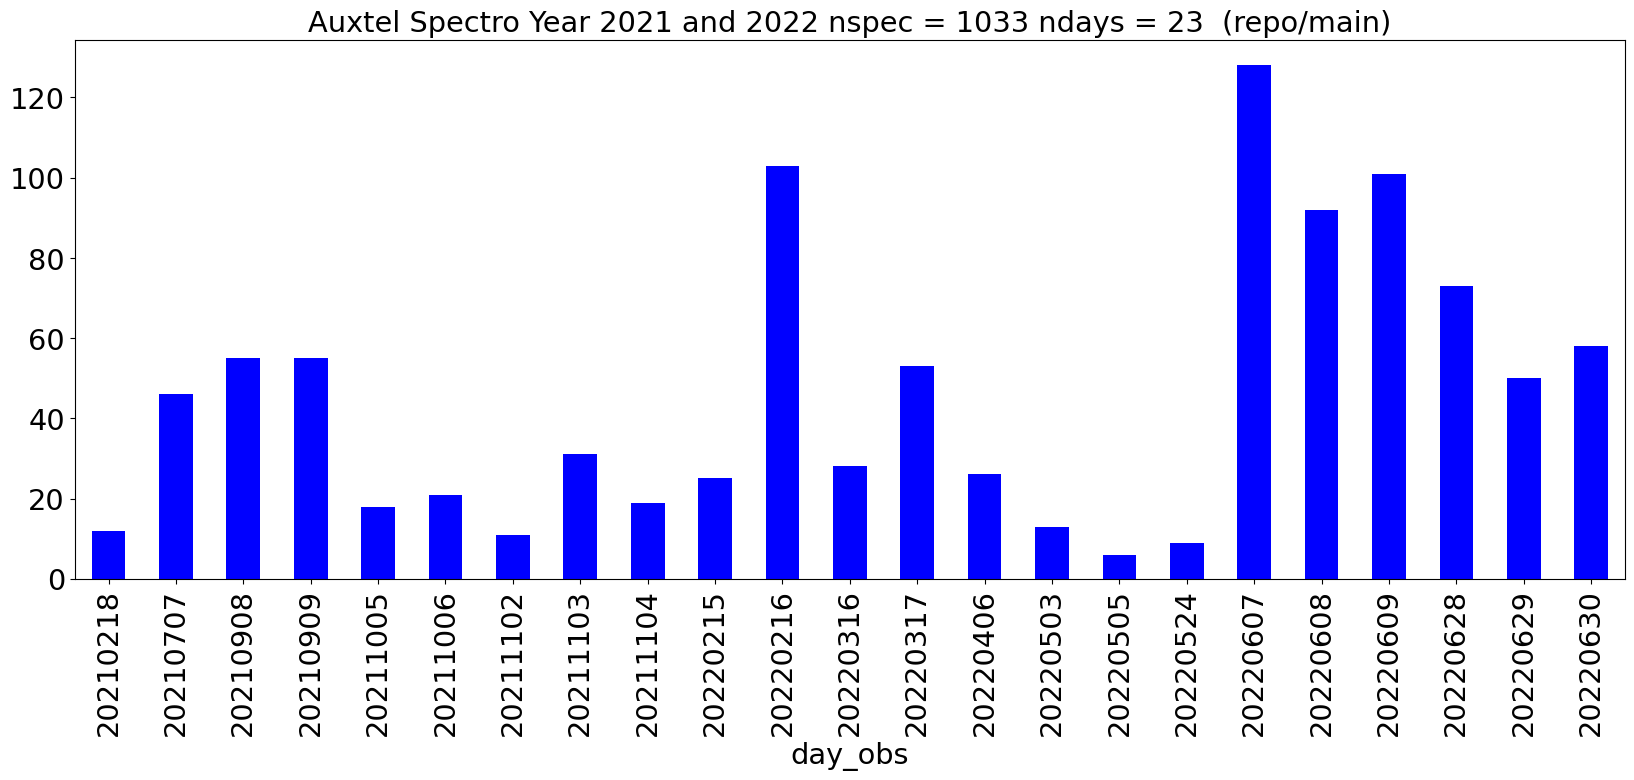

In [20]:
nspec = df_spec_visit_byfilt.sum()
ndays = df_spec_visit_byfilt.count()
suptitle = f"Auxtel Spectro Year 2021 and 2022 nspec = {nspec} ndays = {ndays}  (repo/main)"
fig,ax = plt.subplots(1,1,figsize=(20,7))
df_spec_visit_byfilt.plot(x='day_obs',kind="bar",facecolor="b",ax=ax)
ax.set_title(suptitle)

Text(0.5, 0, 'year,month,day')

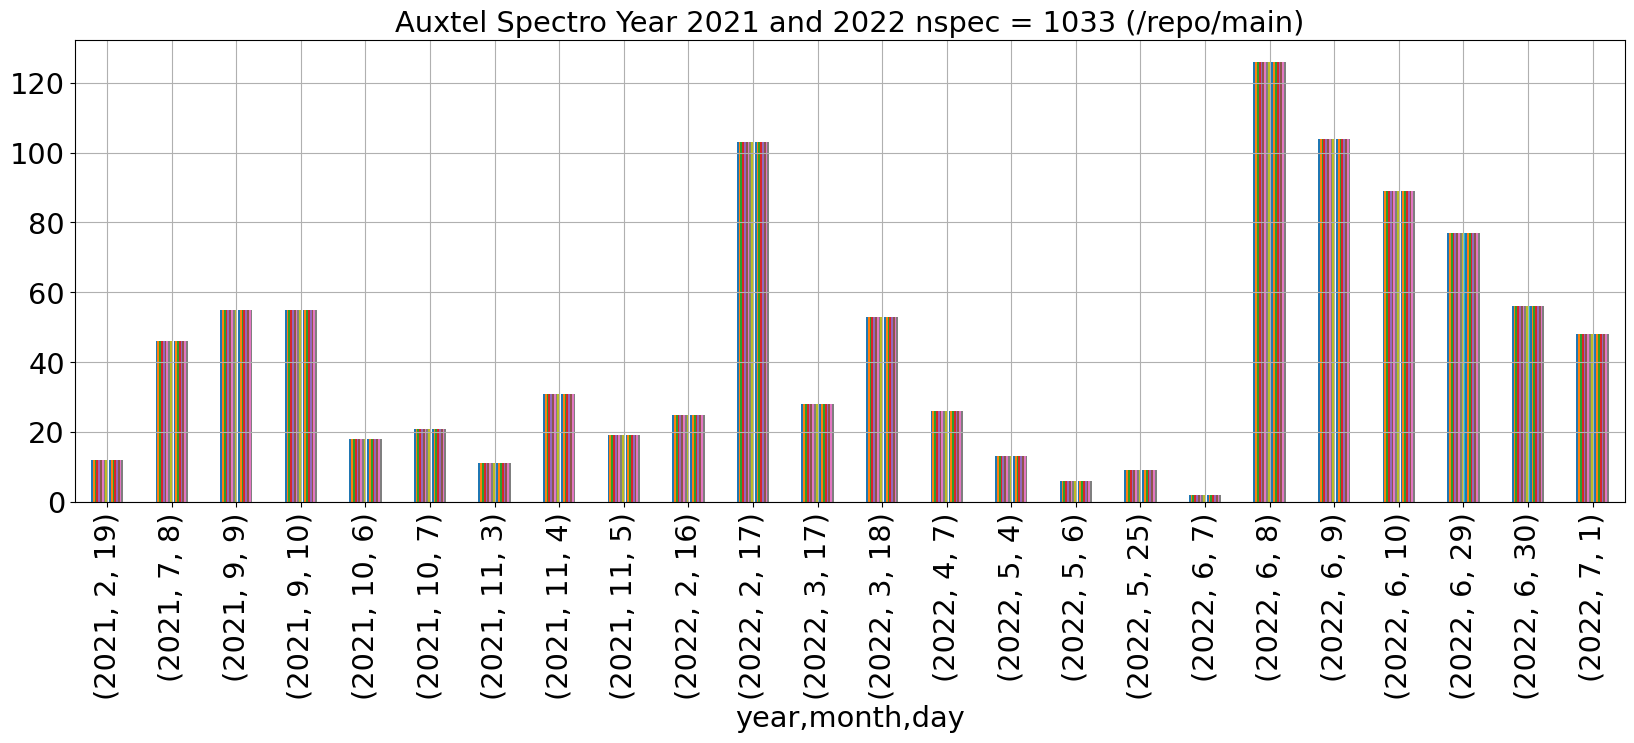

In [21]:
nspec = df_spec.id.count()
suptitle = f"Auxtel Spectro Year 2021 and 2022 nspec = {nspec} (/repo/main)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_spec.groupby([df_spec["time"].dt.year, df_spec["time"].dt.month,df_spec["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

In [22]:
df_2022 = df_spec[df_spec.year == 2022]
df_2021 = df_spec[df_spec.year == 2021]

In [23]:
df_spec["filter"].unique()

array(['empty~holo4_003'], dtype=object)

In [24]:
df_spec.target.unique()

array(['HD 60753', 'HD 160617', 'HD 185975', 'HD 009051', 'HD 14943',
       'HD 200654', 'HD 2811', 'HD 031128', 'spec:HD2811',
       'spec:HD009051', 'spec:HD185975', 'spec:HD14943', 'spec:HD205905',
       'spec:HD200654', 'spec:HD031128', 'HD 38666', 'spec:ETA1DOR',
       'spec:HD38949', 'spec:MUCOL', 'spec:HD37962', 'HD 167060',
       '18 Sco', 'HD 111980', 'spec:HD074000', 'spec:HD111980',
       'spec:HD60753', 'spec:18Sco', 'spec:HD167060', 'spec:HD160617',
       'BD-113759', 'spec:HD142331'], dtype=object)

In [25]:
df_spec.science_program.unique()

array(['unknown'], dtype=object)

In [26]:
df_spec.obs_reason.unique()

array(['science', 'object'], dtype=object)

# Year 2021

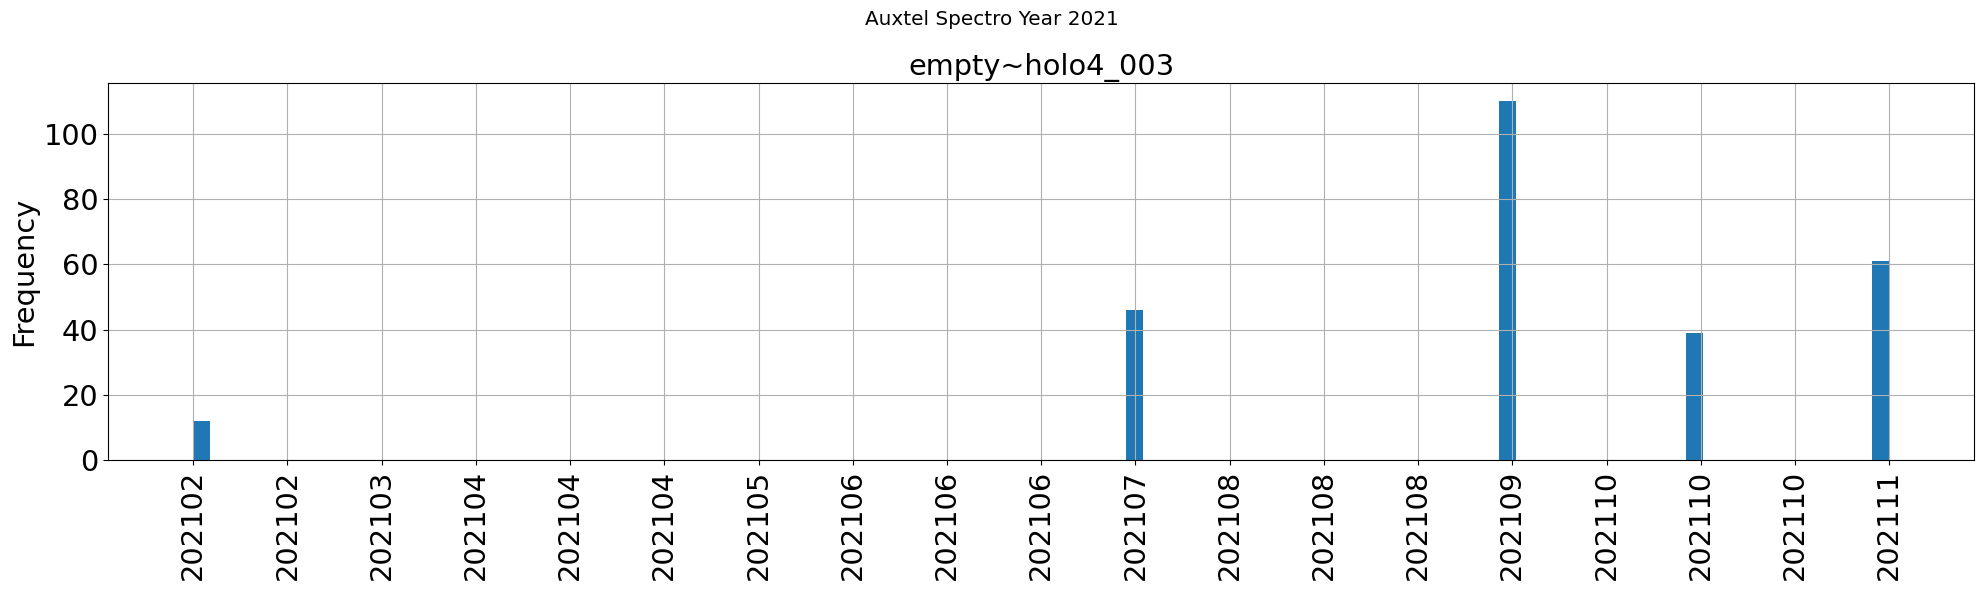

In [27]:
suptitle = "Auxtel Spectro Year 2021"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2021.plot.hist(column=["yearmonth"] ,by="filter",bins=100,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(1)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

In [28]:
df_2021.id.count()

268

Text(0.5, 0, 'year,month,day')

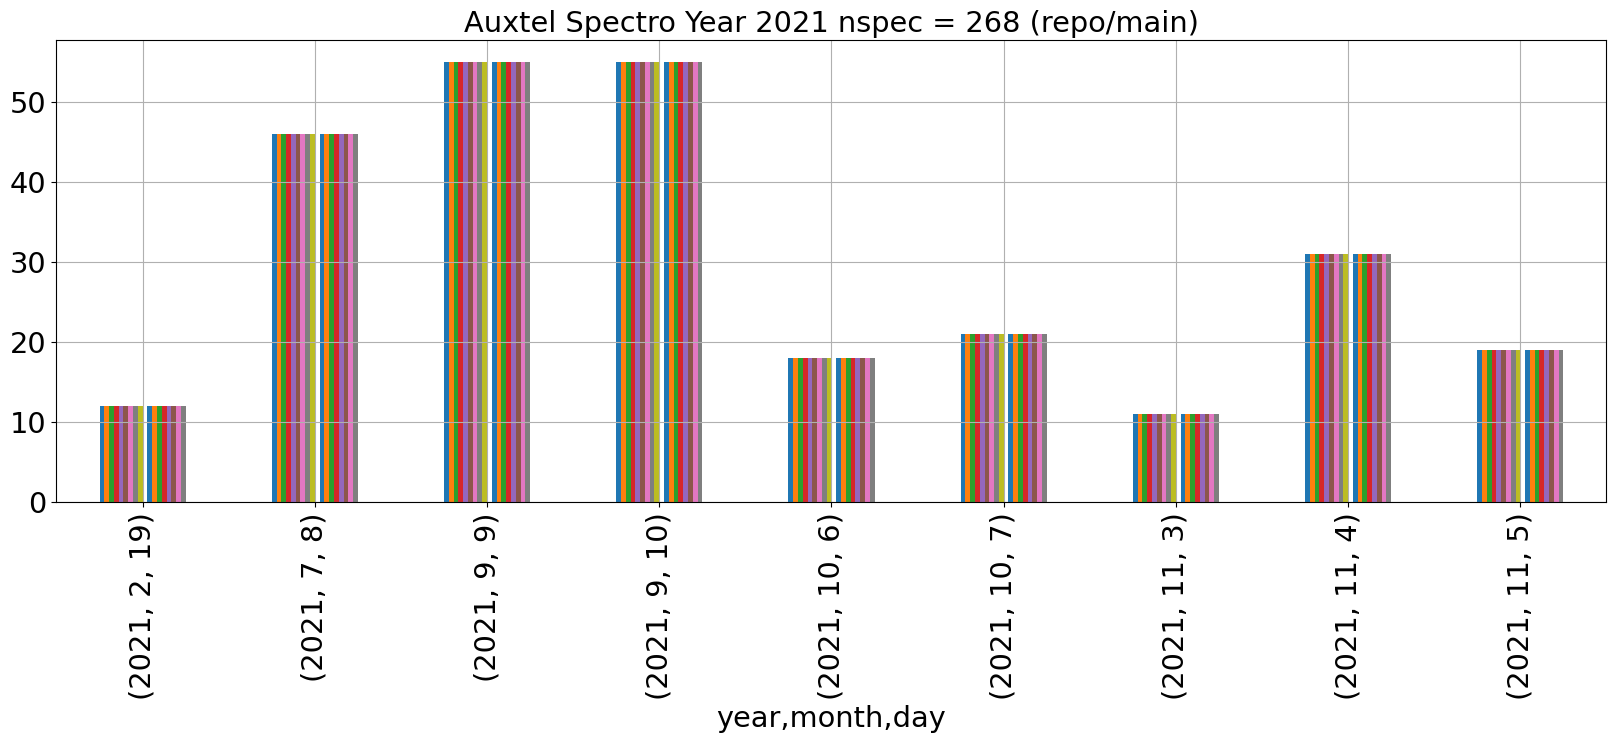

In [29]:
nspec = df_2021.id.count()
suptitle = f"Auxtel Spectro Year 2021 nspec = {nspec} (repo/main)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2021.groupby([df_2021["time"].dt.year, df_2021["time"].dt.month,df_2021["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

In [34]:
df_2021.day_obs.unique()

array([20210218, 20210707, 20210908, 20210909, 20211005, 20211006,
       20211102, 20211103, 20211104])

## Year 2022

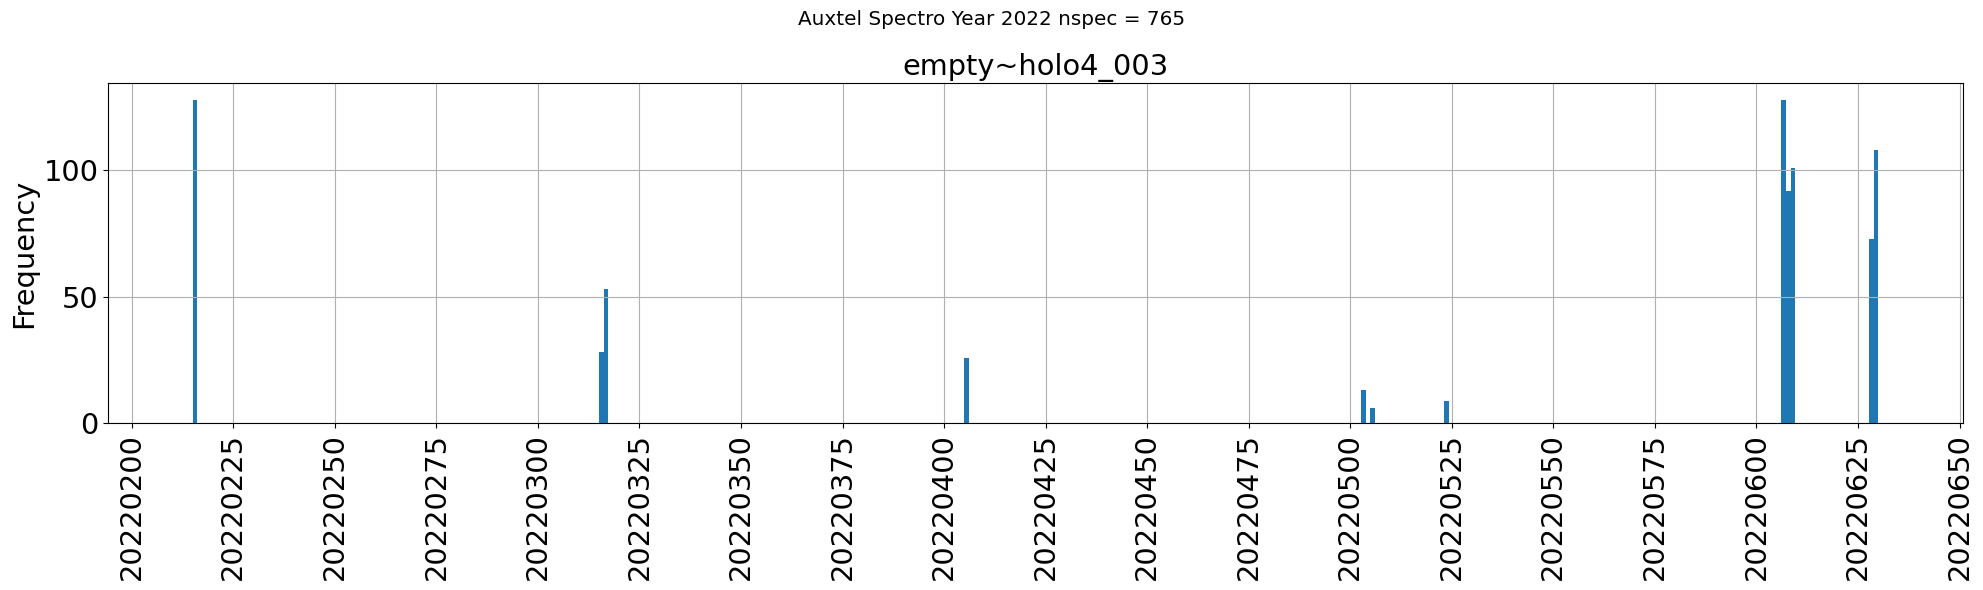

In [31]:
nspec = df_2022.id.count()
suptitle = f"Auxtel Spectro Year 2022 nspec = {nspec}"

fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2022.plot.hist(column=["day_obs"] ,by="filter",bins=365,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(1)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

Text(0.5, 0, 'year,month,day')

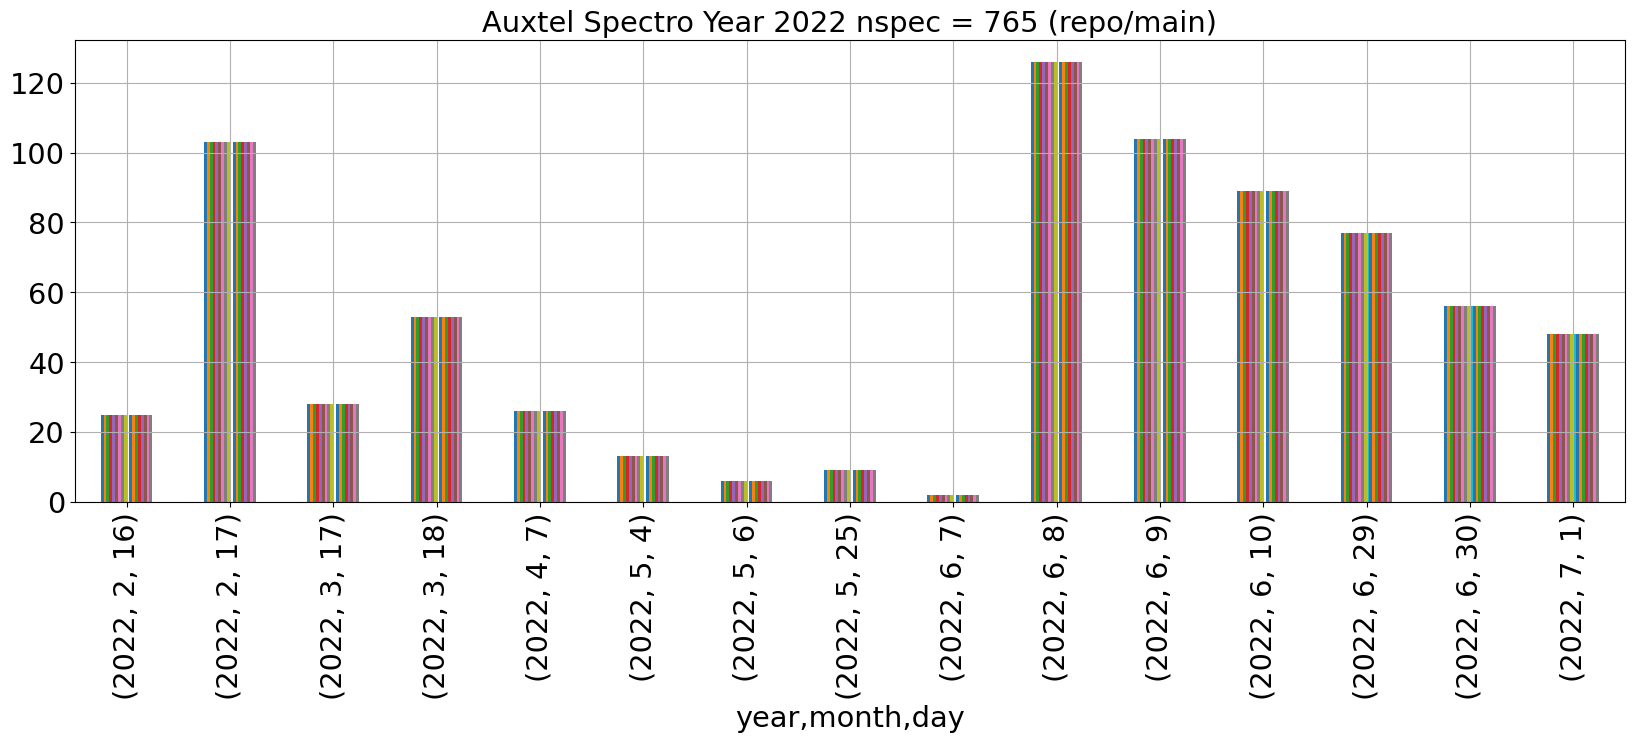

In [32]:
nspec = df_2022.id.count()
suptitle = f"Auxtel Spectro Year 2022 nspec = {nspec} (repo/main)"

fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2022.groupby([df_2022["time"].dt.year, df_2022["time"].dt.month,df_2022["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

In [35]:
df_2022.day_obs.unique()

array([20220215, 20220216, 20220316, 20220317, 20220406, 20220503,
       20220505, 20220524, 20220607, 20220608, 20220609, 20220628,
       20220629, 20220630])